In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import math
%matplotlib inline
import warnings
from matplotlib.ticker import FormatStrFormatter
warnings.filterwarnings('ignore')
from matplotlib import gridspec

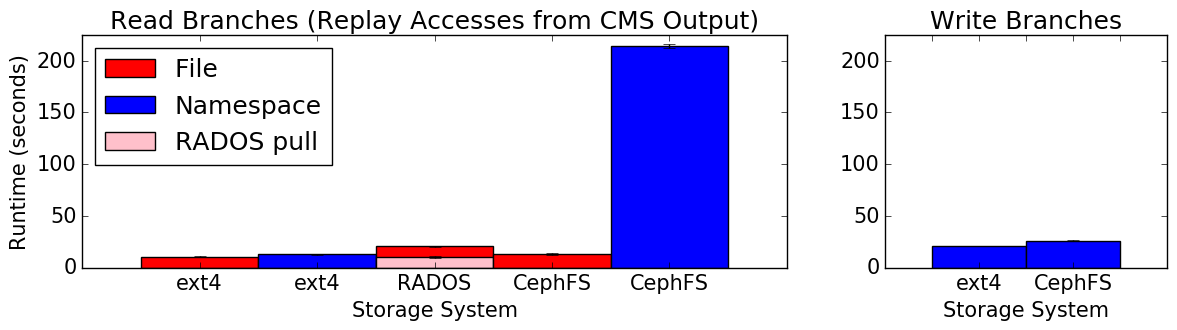

In [29]:
def to_seconds(timestamp):
    ts = timestamp.split(':')
    try: return float(float(ts[0])*60*60 + float(ts[1])*60 + float(ts[2]))
    except: return float(0)
    
def parse(expdir):
    df = pd.DataFrame(columns=['job', 'rtime', 'ts'])
    for run in [0, 1, 2, 3, 4, 5]:
        rundir = expdir + '-run' + str(run)
        with open(rundir + '/summary.txt') as f:
            d = pd.read_csv(f, names=['job', 'delta', 'time'])
            d['rtime'] = d['delta'].apply(to_seconds)
            del d['time'], d['delta']
            d['run'] = run
            df = df.append(d, ignore_index=True)
    return df.pivot(index='run', values='rtime', columns='job')

font = {'size'   : 15}; matplotlib.rc('font', **font)
args = {'width': 1, 'capsize': 4, 'ecolor': 'black'}
#fig, ax = plt.subplots(1, 1, figsize=(14, 3))
fig = plt.figure(figsize=(14,3))
gs = plt.GridSpec(1, 2, width_ratios=[5, 2]) 


df = parse('../results')
ax = plt.subplot(gs[0])
ax.bar([0.5], df['read_hep_ext4'].mean(), yerr=df['read_hep_ext4'].std(), color='red',  label='File', **args)
ax.bar([1.5], df['read_fpb_ext4'].mean(), yerr=df['read_fpb_ext4'].std(), color='blue', label='Namespace', **args)
ax.bar([2.5], df['get'].mean() + df['read_hep_ext4'].mean(), yerr=df['read_hep_ext4'].std(), color='red', **args)
ax.bar([2.5], df['get'].mean(), yerr=df['get'].std(), color='pink', label='RADOS pull', **args)
ax.bar([3.5], df['read_cephfs'].mean(), yerr=df['read_cephfs'].std(), color='red', **args)
ax.bar([4.5], df['read_fpb_cephfs'].mean(), yerr=df['read_fpb_cephfs'].std(), color='blue', **args)
ax.set_xticklabels(["", "ext4", "ext4", "RADOS","CephFS", "CephFS"])
ax.set_ylim(0, 225)
ax.set_ylabel("Runtime (seconds)")
ax.set_xlabel("Storage System")
ax.set_title("Read Branches (Replay Accesses from CMS Output)")
ax.legend(loc='upper left')
ax = plt.subplot(gs[1])
ax.bar([0.5], df['write_fpb_ext4'].mean(), yerr=df['write_fpb_ext4'].std(), color='blue', **args)
ax.bar([1.5], df['write_fpb_cephfs'].mean(), yerr=df['write_fpb_cephfs'].std(), color='blue', **args)
ax.set_ylim(0, 225)
ax.set_xlim(0, 3)
ax.set_xticklabels(["", "", "ext4", "", "CephFS"])
ax.set_title("Write Branches")
ax.set_xlabel("Storage System")

plt.savefig('rdwr_branches.png', dpi=300, bbox_inches='tight')

In [45]:
print "write bandwidth = " + str((1745997813/df['put'].mean())/(1024*1024))
print "read  bandwidth = " + str((1745997813/df['get'].mean())/(1024*1024))

write bandwidth = 122.536545198
read  bandwidth = 166.141907775
